In [4]:
import numpy as np
import pickle
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision import transforms, models
from bs4 import BeautifulSoup
from glob import glob

%matplotlib inline

In [51]:
annotations = glob('./data/annotations/*.xml')

names = []
bounding_boxes = []
img_paths = []
n_masks = []

for a in annotations:
    with open(a, 'rb') as f:
        content = f.read()

    soup = BeautifulSoup(content, 'xml')

    filename = soup.find('filename').text
    objects = soup.find_all('object')
    n = 0
    for o in objects:
        name = o.find('name').text
        xmin = int(o.find('xmin').text)
        xmax = int(o.find('xmax').text)
        ymin = int(o.find('ymin').text)
        ymax = int(o.find('ymax').text)

        names.append(name)
        bounding_boxes.append([xmin, ymin, xmax, ymax])

        n = n + 1

    img_paths.append(filename)
    n_masks.append(n)

In [52]:
bounding_boxes[1]

[185, 100, 226, 144]

In [53]:
BASE = './data/images/'
faces = []
j = 0

for i in range(len(img_paths)):
    full_path = BASE + img_paths[i]
    img = cv2.imread(full_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    while(j < len(bounding_boxes)):
        for k in range(n_masks[i]):
            face = img[bounding_boxes[j][1]:bounding_boxes[j][3], bounding_boxes[j][0]:bounding_boxes[j][2]]
            faces.append(face)
        
            j += 1
            
        break

In [60]:
IMG_SIZE = 64
encoded_labels = []
unique_labels = []

for i in range(len(faces)):
    faces[i] = cv2.resize(faces[i], (IMG_SIZE, IMG_SIZE))
    
for l in names:
    if l not in unique_labels:
            unique_labels.append(l)
    if l == 'without_mask':
        encoded_labels.append(0)
    elif l == 'with_mask':
        encoded_labels.append(1)
    else:
        encoded_labels.append(2)

In [64]:
print("Total number of unique labels:", len(unique_labels))
print("Labels:", unique_labels)

Total number of unique labels: 3
Labels: ['without_mask', 'with_mask', 'mask_weared_incorrect']


In [59]:
print("Total number of images:", len(faces))
print("'with_mask' labeled images:", sum(n == 'with_mask' for n in names))
print("'without_mask' labeled images:", sum(n == 'without_mask' for n in names))
print("'mask_weared_incorrect' labeled images:", sum(n == 'mask_weared_incorrect' for n in names))

Total number of images: 4072
'with_mask' labeled images: 3232
'without_mask' labeled images: 717
'mask_weared_incorrect' labeled images: 123


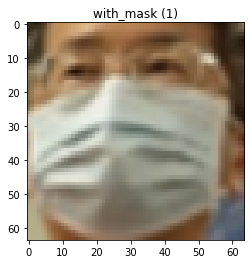

In [7]:
idx = 20

plt.imshow(faces[idx])
plt.title(labels[idx] + ' (' + str(encoded_labels[idx]) + ')')
plt.show()

In [43]:
# save preprocessed data into a small pickle file to save time
data_pickle = {'features': faces, 'labels': labels}

with open('face_mask_dataset.pickle', 'wb') as f:
    pickle.dump(data_pickle, f)

## Checkpoint

In [5]:
# load the saved pickle file
with open('face_mask_dataset.pickle', 'rb') as f:
    loaded_data = pickle.load(f)

features = loaded_data['features']
labels = loaded_data['labels']

In [10]:
IMG_SIZE = 64
split_val = 0.8

features = np.asarray(features)
features = np.reshape(features, [len(features), 3, IMG_SIZE, IMG_SIZE])
labels = np.asarray(labels)
n_train = int(split_val * len(features))

train_features = features[:n_train]
train_labels = labels[:n_train]
test_features = features[n_train:]
test_labels = labels[n_train:]

train_data = torch.utils.data.TensorDataset(torch.from_numpy(train_features), torch.from_numpy(train_labels))
test_data = torch.utils.data.TensorDataset(torch.from_numpy(test_features), torch.from_numpy(test_labels))

BATCH_SIZE = 32
NUM_WORKERS = 0
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

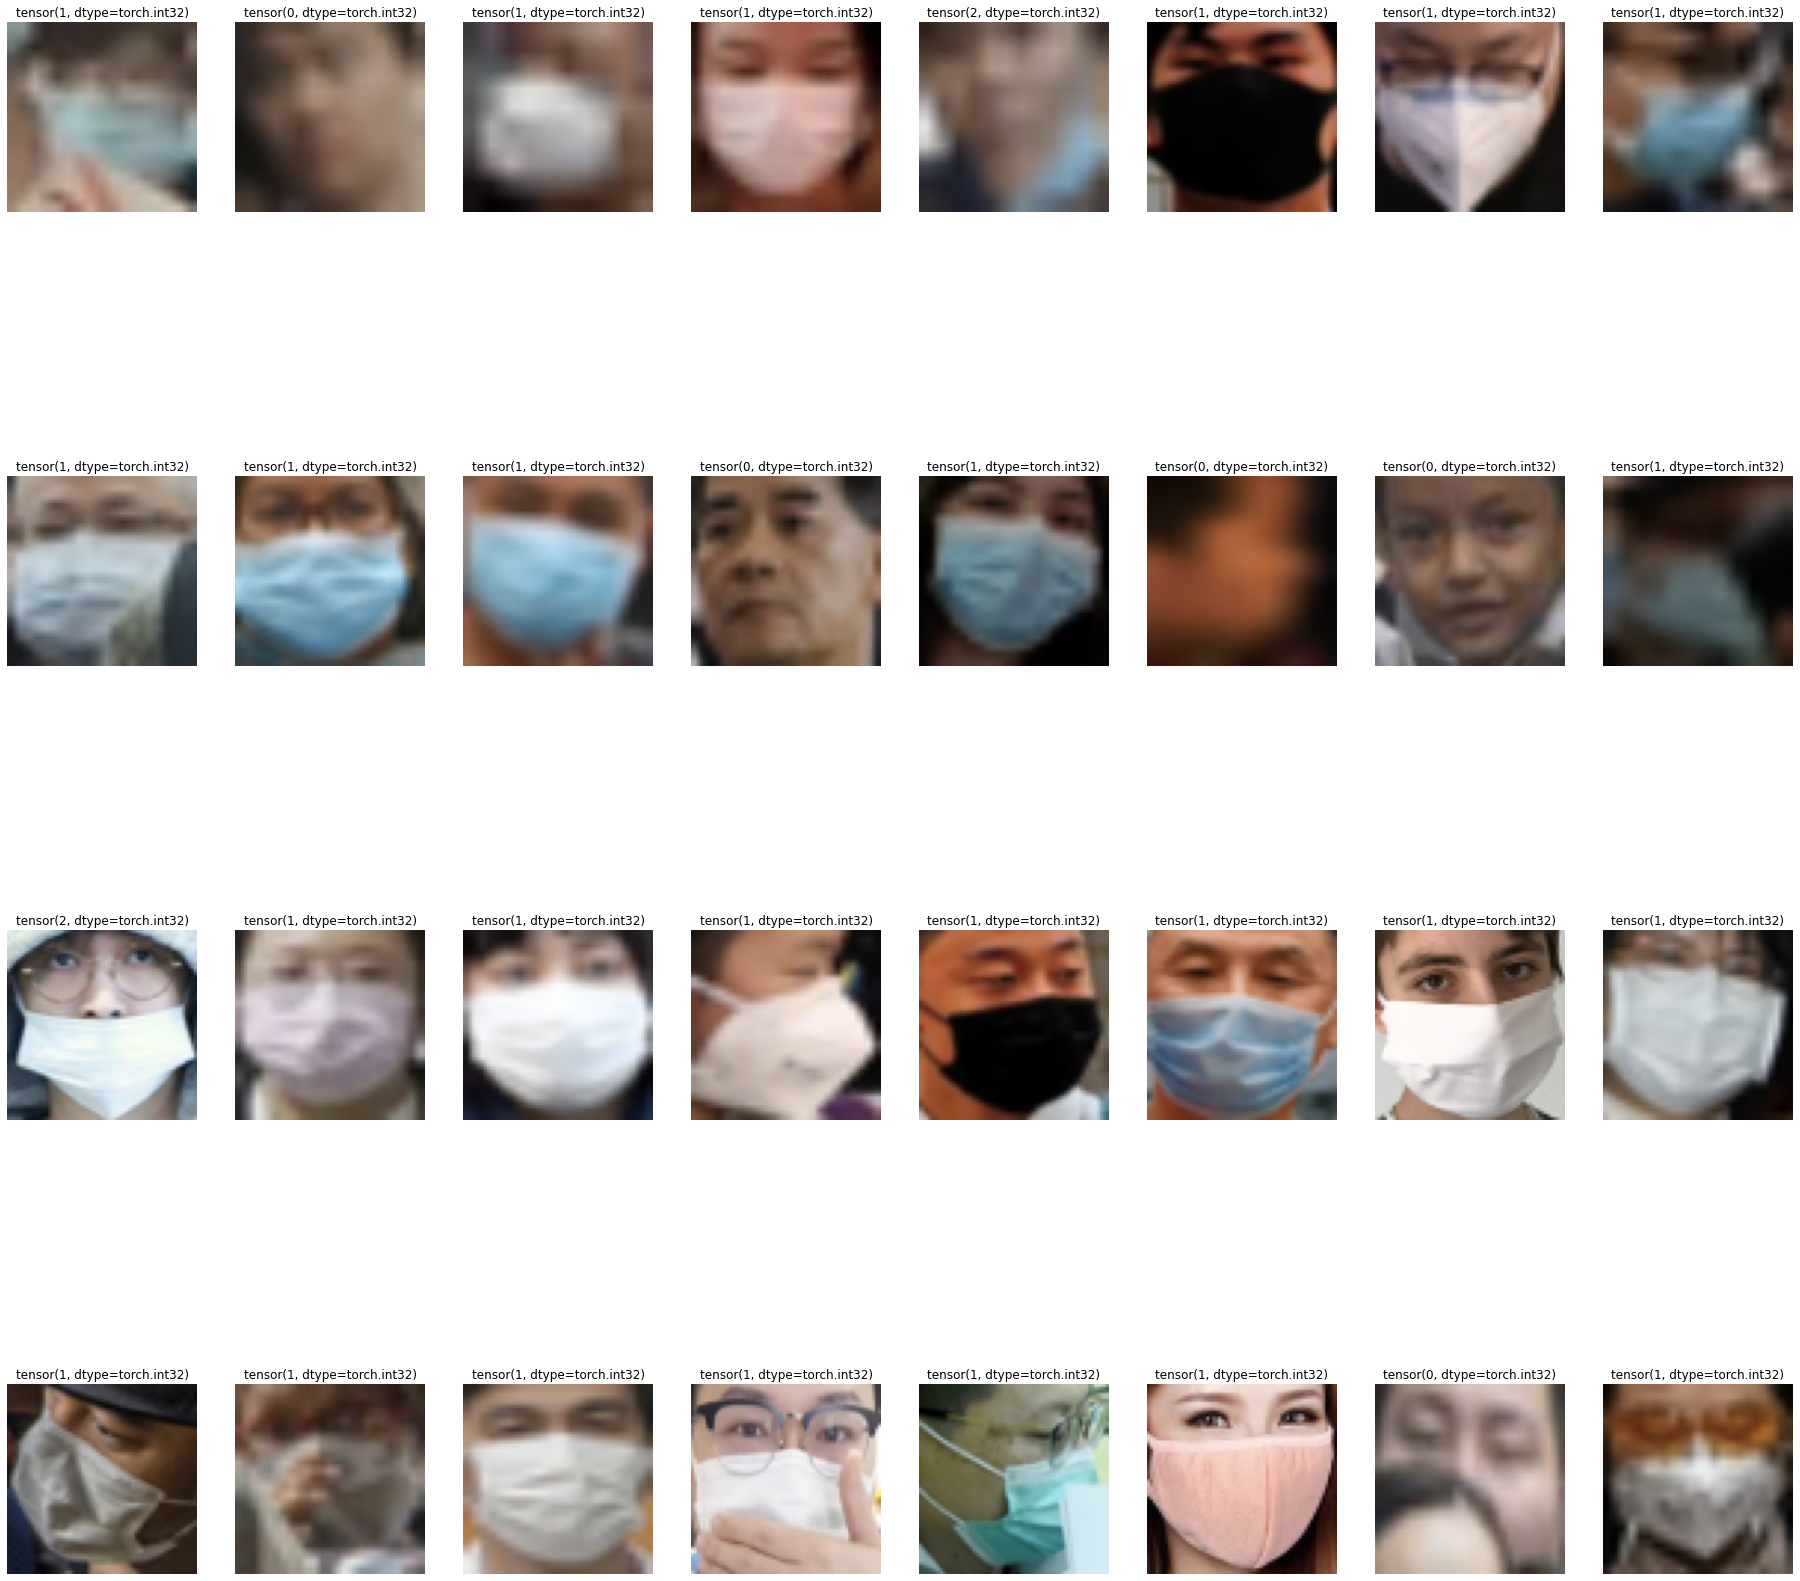

In [11]:
train_batch_x, train_batch_y = iter(train_loader).next()
train_batch_x = train_batch_x.view(BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3)
fig, ax = plt.subplots(4, 8, figsize=(32,32))

for (x, y, axi) in zip(train_batch_x, train_batch_y, ax.flatten()):
    axi.imshow(x)
    axi.set_title(y)
    axi.axis('off')

In [12]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, (3,3), padding=1)
        self.conv2 = nn.Conv2d(16, 32, (3,3), padding=1)
        self.conv3 = nn.Conv2d(32, 64, (3,3), padding=1)
        self.pool = nn.MaxPool2d((2,2), 2)
        
        self.fc1 = nn.Linear(64*8*8, 128)
        self.fc2 = nn.Linear(128, 3)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(-1, 64*8*8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [19]:
use_cuda = torch.cuda.is_available()

model = Model()
if use_cuda:
    print('Training using GPU:', torch.cuda.get_device_name(0))
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Training using GPU: GeForce RTX 2070 SUPER


In [20]:
def train(num_epochs, model, loader, crit, opt, use_cuda, save_path=''):
    
    training_losses = []
    
    for i in range(num_epochs):
        training_loss = 0.0
        
        model.train()
        for batch, (feature, label) in enumerate(loader):
            feature = feature.to(torch.float)
            label = label.to(torch.long)
            if use_cuda:
                feature, label = feature.cuda(), label.cuda()
            
            opt.zero_grad()
            
            output = model(feature)
            loss = crit(output, label)
            loss.backward()
            opt.step()
            
            training_loss = training_loss + (1 / (batch + 1)) * (loss.data - training_loss)
            
        print("Epoch #{} | Training loss: {}".format(i+1, training_loss))
        training_losses.append(training_loss)
    
    if len(save_path) > 0:
        print('Saving model...')
        torch.save(model.state_dict(), save_path)
        print('Model saved:', save_path)
        
    return model, training_losses

In [21]:
NUM_EPOCHS=10
final_model, training_losses = train(NUM_EPOCHS, model, train_loader, criterion, optimizer, use_cuda, save_path='adam_lr1e-3_epochs10.pt')

Epoch #1 | Training loss: 1.136486530303955
Epoch #2 | Training loss: 0.33401602506637573
Epoch #3 | Training loss: 0.3014316260814667
Epoch #4 | Training loss: 0.2982245981693268
Epoch #5 | Training loss: 0.24058584868907928
Epoch #6 | Training loss: 0.19723917543888092
Epoch #7 | Training loss: 0.1580202430486679
Epoch #8 | Training loss: 0.14430561661720276
Epoch #9 | Training loss: 0.11040487140417099
Epoch #10 | Training loss: 0.09994804114103317
Saving model...
Model saved: adam_lr1e-3_epochs10.pt


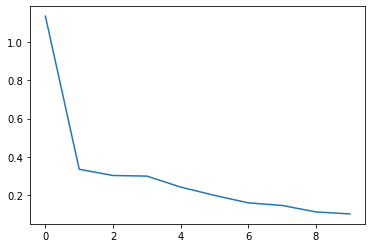

In [22]:
plt.plot(range(NUM_EPOCHS), training_losses)

In [41]:
def evaluate(model, loader, crit, use_cuda):
    
    test_loss = 0.0
    num_correct = 0
    total_data = 0
    
    model.eval()
    for batch, (feature, label) in enumerate(loader):
        feature = feature.to(torch.float)
        label = label.to(torch.long)
        if use_cuda:
            feature, label = feature.cuda(), label.cuda()
        
        output = model(feature)
        loss = crit(output, label)
        
        test_loss = test_loss + (1/(batch+1)) * (loss.data - test_loss)
        test_losses.append(test_loss)
        total_data = total_data + feature.size(0)
        
        preds = output.data.max(1)[1]
        num_correct += np.sum(np.squeeze(preds.eq(label.data.view_as(preds))).cpu().numpy())
    
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {:.2f}%'.format(num_correct / total_data * 100))

In [42]:
evaluate(final_model, test_loader, criterion, use_cuda)

Test Loss: 0.3703325092792511
Test Accuracy: 91.53%


## Checkpoint 2

In [24]:
MODEL_PATH = 'adam_lr1e-3_epochs10.pt'

use_cuda = torch.cuda.is_available()
model = Model()

if use_cuda:
    model = model.cuda()

model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [25]:
model

Model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)